## Rover Project Test Notebook
This notebook contains the functions from the lesson and serves 
as a place you can test things out before pushing them to the 
autonomous mode scripts.

In [119]:
%matplotlib inline
# %matplotlib qt 
# Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
# Make some of the relevant imports
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc


Next, read in and display a random image from the `smaller_test_dataset` folder

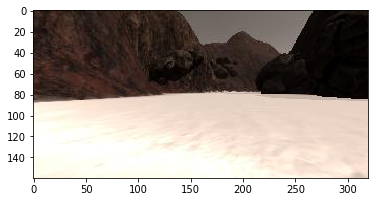

In [120]:
import glob
path = '../smaller_test_dataset/IMG/*'
img_list = glob.glob(path)
# Grab a random image and display it
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
plt.imshow(image)

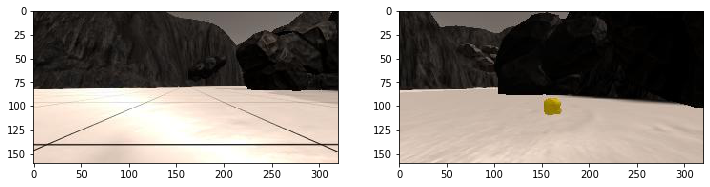

In [121]:
# In the simulator you can toggle on a grid on the ground for calibration
# You can also toggle on the rock samples with the 0 (zero) key.  
# Here's an example of the grid and one of the rocks
example_grid = '../calibration_images/example_grid1.jpg'
example_rock = '../calibration_images/example_rock1.jpg'
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)

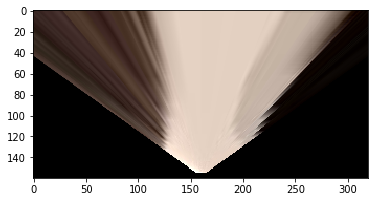

In [122]:
# Define a function to perform a perspective transform
# I've used the example grid image above to choose source points for the
# grid cell in front of the rover (each grid cell is 1 square meter in the sim)
def perspect_transform(img):
    
    img_size = (img.shape[1], img.shape[0])
    # Define calibration box in source (actual) and destination (desired) coordinates
    # These source and destination points are defined to warp the image
    # to a grid where each 10x10 pixel square represents 1 square meter
    dst_size = 5 
    # Set a bottom offset to account for the fact that the bottom of the image 
    # is not the position of the rover but a bit in front of it
    bottom_offset = 6
    src = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
    dst = np.float32([[img_size[0]/2 - dst_size, img_size[1] - bottom_offset],
                      [img_size[0]/2 + dst_size, img_size[1] - bottom_offset],
                      [img_size[0]/2 + dst_size, img_size[1] - 2*dst_size - bottom_offset], 
                      [img_size[0]/2 - dst_size, img_size[1] - 2*dst_size - bottom_offset],
                      ])
       
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size)# keep same size as input image
    return warped

warped = perspect_transform(image)
plt.imshow(warped)
#scipy.misc.imsave('../output/warped_example.jpg', warped)

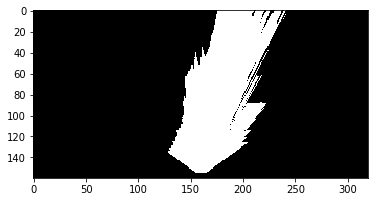

In [136]:
# Identify pixels below the threshold
# Threshold of RGB > 160 does a nice job of identifying ground pixels only
def color_thresh(img, rgb_thresh=(160, 160, 160)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all thre threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select

threshed = color_thresh(warped)
plt.imshow(threshed, cmap='gray')
#scipy.misc.imsave('../output/warped_threshed.jpg', threshed*255)

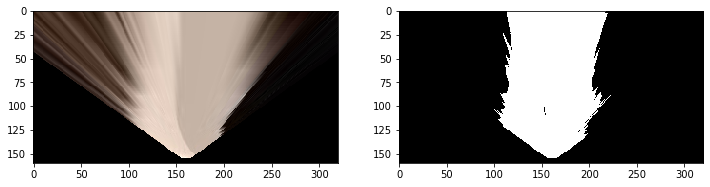

In [137]:
# Try warping and thresholding random images
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
warped = perspect_transform(image)
threshed = color_thresh(warped)
fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(warped)
plt.subplot(122)
plt.imshow(threshed, cmap='gray')

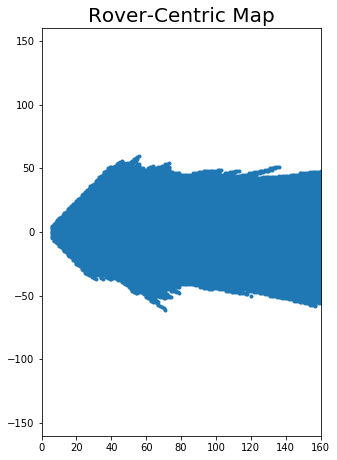

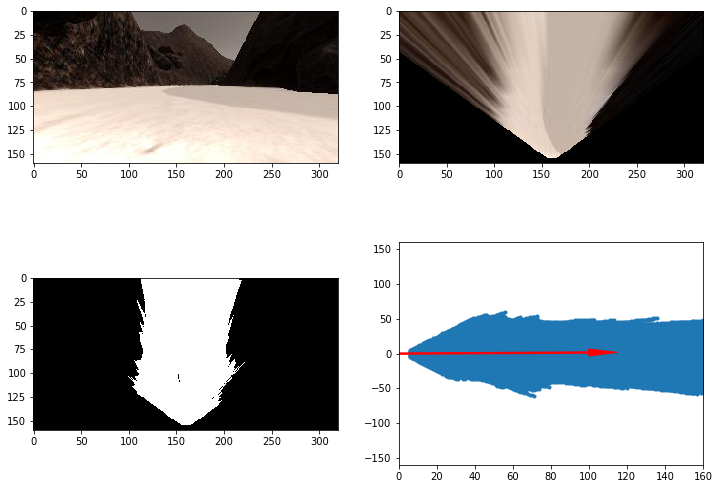

In [138]:
# Define a function to calculate distances and angles to all "on" pixels (navigable)
def rover_coords(binary_img):
    # Extract xpos and ypos pixel positions from binary_img and
    # Convert xpos and ypos to rover-centric coordinates
    width, height = binary_img.shape
    ypos, xpos = binary_img.nonzero()
    x_pixel = -(ypos - width).astype(np.float)
    y_pixel = -(xpos - height/2).astype(np.float)

    return x_pixel, y_pixel


# Define a function to apply a rotation to pixel positions
def rotate_pix(xpix, ypix, yaw):
    # TODO:
    # Convert yaw to radians
    # Apply a rotation
    # Return the result
    yaw = yaw * 180 / np.pi
    xpix_rot = (xpix * np.cos(yaw)) - (ypix * np.sin(yaw))
    ypix_rot = (xpix * np.sin(yaw)) + (ypix * np.cos(yaw))
    return x_rot, y_rot

# Define a function to perform a translation
def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # TODO:
    # Apply a scaling and a translation
    # Return the result
    x_trans = (xpix_rot / scale) - xpos
    y_trans = (y_pix_rot / scale) + ypos
    return x_trans, y_trans
    
def to_polar_coords(xpix, ypix):
    # Calculate distance to each pixel
    dist = np.sqrt(xpix**2 + ypix**2)
    # Calculate angle using arctangent function
    angles = np.arctan2(ypix, xpix)
    return dist, angles
    
def to_radial_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(x_pixel, y_pixel)
    return dist, angles

def pix_to_world(dist, angles, x_rover, y_rover, yaw_rover):
    # Map pixels from rover space to world coords
    pix_angles = angles + (yaw_rover * np.pi/180)    
    x_pix_world = np.clip(np.int_((dist * np.sin(pix_angles)) + (x_rover)), 0, 499)
    y_pix_world = np.clip(np.int_((dist * np.cos(pix_angles)) + (y_rover)), 0, 499)
    # Update the map
    return x_pix_world, y_pix_world

# Define a function to take a histogram of angular values
def angular_hist(angles, nbins=16):
    angle_hist = np.histogram(angles, bins=nbins)
    hist_values = angle_hist[0]
    binsize = angle_hist[1][1] - angle_hist[1][0]
    bin_centers = angle_hist[1][:-1] + binsize/2
    peak_idx = np.argmax(hist_values)
    peak_dir = bin_centers[peak_idx]
    peak_val = hist_values[peak_idx]
    return peak_dir, peak_val, hist_values, bin_centers, binsize


# Grab another random image
# idx = np.random.randint(0, len(img_list)-1)
# image = mpimg.imread(img_list[idx])
warped = perspect_transform(image)
# threshed = color_thresh(warped)

### new
# Perform warping and color thresholding

colorsel = color_thresh(warped, rgb_thresh=(160, 160, 160))
# Extract x and y positions of navigable terrain pixels
# and convert to rover coordinates
xpix, ypix = rover_coords(colorsel)

# Plot the map in rover-centric coords
fig = plt.figure(figsize=(5, 7.5))
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
plt.title('Rover-Centric Map', fontsize=20)
plt.show() # Uncomment if running on your local machine


# # Calculate pixel values in rover-centric coords and distance/angle to all pixels
warped = perspect_transform(image) # Perform perspective transform
colorsel = color_thresh(warped, rgb_thresh=(160, 160, 160)) # Threshold the warped image
xpix, ypix = rover_coords(colorsel)  # Convert to rover-centric coords
distances, angles = to_polar_coords(xpix, ypix) # Convert to polar coords
avg_angle = np.mean(angles) # Compute the average angle

# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(colorsel, cmap='gray')
plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(avg_angle)
y_arrow = arrow_length * np.sin(avg_angle)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)
plt.show()


In [139]:
# Define a function to pass stored images to
# This function will be used by moviepy to create an output video
def process_image(img):
    
    warped = perspect_transform(img)
    threshed = color_thresh(warped)
    
    if data.count < len(data.images):
        # Get pixel values and angle/distance measurements to navigable surface pixels
        xpix, ypix = rover_coords(threshed)
        dist, angles = to_radial_coords(xpix, ypix)
        mean_dir = np.mean(angles)
        
        # Convert yaw values to radians        
        yaw_rover = data.yaw[data.count] * np.pi/180

        # Compute yaw values and x,y positions of navigable pixels in world space
        x_world, y_world = pix_to_world(dist/10, angles, data.xpos[data.count], data.ypos[data.count], yaw_rover)
        # Update the map
        data.worldmap[x_world, y_world, 2] += 10
        
        # Update count to keep track of where were are in the data
        data.count += 1
    
    # Create output to show original image, processing and mapmaking
    out = np.zeros((img.shape[0] + data.worldmap.shape[0], img.shape[1]*2, 3))
    out[0:img.shape[0], 0:img.shape[1]] = img
    out[0:img.shape[0], img.shape[1]:] = warped
    thresh_3d = np.dstack((threshed*255, threshed*255, threshed*255))
    out[img.shape[0]:2*img.shape[0], img.shape[1]:] = thresh_3d
    out[img.shape[0]:, :data.worldmap.shape[0]] = np.rot90(data.worldmap)
    
    cv2.putText(out,"Blue = navigable terrain", (img.shape[0]-20,img.shape[0]+20), 
                cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    return out

In [141]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip
from IPython.display import HTML
output = 'test_mapping.mp4'

import pandas as pd
df = pd.read_csv('../larger_test_dataset/robot_log.csv', sep=";")

img_list_sorted = df["Path"].tolist()

# Creating a class to be the data container
# Maps are instantiated as 2k x 2k grids corresponding to a 200m x 200m space
# This encompasses the full range of output position values in x and y from the sim
class Databucket():
    def __init__(self):
        self.images = img_list_sorted  
        self.xpos = df["X_Position"].values
        self.ypos = df["Y_Position"].values
        self.yaw = df["Yaw"].values
        self.count = 0
        self.worldmap = np.zeros((200, 200, 3)).astype(np.float)
        
data = Databucket()
clip = ImageSequenceClip(img_list_sorted, fps=60)
new_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time new_clip.write_videofile(output, audio=False)

t:   0%|          | 0/1123 [00:00<?, ?it/s, now=None]

Moviepy - Building video test_mapping.mp4.
Moviepy - Writing video test_mapping.mp4



Moviepy - Done !
Moviepy - video ready test_mapping.mp4
CPU times: user 6.81 s, sys: 502 ms, total: 7.31 s
Wall time: 8.66 s
